In [285]:
import networkx as nx
import numpy as np 
from openai import OpenAI
import io
import matplotlib.pyplot as plt 
import base64
import requests
from typing import List

import warnings
warnings.filterwarnings("ignore")

# Replace with your own OpenAI api key 
client = OpenAI(api_key=open("/Users/mosobay/Dropbox (MIT)/research/openai_api", "r").read().strip())
api_key = open("/Users/mosobay/Dropbox (MIT)/research/openai_api", "r").read().strip()
headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

# Helper functions 

In [316]:
def get_graph_base64(nx_graph):
    graphviz_io = io.BytesIO()
    plt.figure()
    nx.draw_networkx(nx_graph)
    plt.savefig(graphviz_io, format="jpg")
    graphviz_io.seek(0)
    graphviz_base64data = base64.b64encode(graphviz_io.read()).decode()
    
    return graphviz_base64data

def get_graph_base64_voting(nx_graph, node_votes):
    graphviz_io = io.BytesIO()
    plt.figure()
    nx.draw_networkx(nx_graph, node_color=node_votes)
    plt.savefig(graphviz_io, format="jpg")
    graphviz_io.seek(0)
    graphviz_base64data = base64.b64encode(graphviz_io.read()).decode()
    
    return graphviz_base64data


def query_gpt4vision(query_string: str, list_networks: List[nx.classes.graph.Graph]):
    list_graph_base64 = [get_graph_base64(x) for x in list_networks]
    payload_content = [{"type": "text", "text": query_string}]
    
    for graph in list_graph_base64:
        payload_content.append({"type": "image_url",
                                "image_url": {"url": f"data:image/jpeg;base64,{graph}"}})
    
    
    payload = {
        "model": "gpt-4-vision-preview",
        "messages": [{"role": "user",
                      "content": payload_content}],
        "max_tokens": 1000}
    
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    response_str = response.json()["choices"][0]["message"]["content"]
    
    return response_str, response


def query_gpt4text(query_string: str, network: nx.classes.graph.Graph):
    
    system_prompt = f"""You will be asked to answer questions about the following adjacency matrix. An adjacency matrix describes how nodes in a social network are connected, where agents are indexed by number (the first row describes how Agent 0 is connected to other agents, and so forth). The adjacency matrix is:\n{np.array2string(nx.adjacency_matrix(network).todense())}"""    
    nx.draw_networkx(network)
    response = client.chat.completions.create(
      model="gpt-4-1106-preview", max_tokens=1000,
      messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": query_string}
      ]
    )
    
    response_str = response.choices[0].message.content
    
    return response_str, response


def query_gpt4vision_voting(query_string: str, 
                     list_networks: List[nx.classes.graph.Graph],
                     list_votes: List[List[str]]):
    
    list_graph_base64 = [get_graph_base64_voting(list_networks[x], list_votes[x]) for x in range(len(list_networks))]
    payload_content = [{"type": "text", "text": query_string}]
    
    for graph in list_graph_base64:
        payload_content.append({"type": "image_url",
                                "image_url": {"url": f"data:image/jpeg;base64,{graph}"}})
    
    
    payload = {
        "model": "gpt-4-vision-preview",
        "messages": [{"role": "user",
                      "content": payload_content}],
        "max_tokens": 1000}
    
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    response_str = response.json()["choices"][0]["message"]["content"]
    
    return response_str, response



def query_gpt4text_voting(query_string: str, network: nx.classes.graph.Graph, list_votes: List[str]):
    
    system_prompt = f"""You will be asked to answer questions about the following adjacency matrix. An adjacency matrix describes how nodes in a social network are connected, where agents are indexed by number (the first row describes how Agent 0 is connected to other agents, and so forth). The adjacency matrix is:\n{np.array2string(nx.adjacency_matrix(network).todense())}"""    
    system_prompt_votes = f"""Each agent in the node has chosen either 'red' or 'blue', as given in the follow JSON:\n{str(dict(zip(['Agent {}'.format(x) for x in range(len(network.nodes))],list_votes)))}"""
    
    nx.draw_networkx(network, node_color=list_votes)
    response = client.chat.completions.create(
      model="gpt-4-1106-preview", max_tokens=1000,
      messages=[
        {"role": "system", "content": system_prompt},
        {"role": "system", "content": system_prompt_votes},
        {"role": "user", "content": query_string}
      ]
    )
    
    response_str = response.choices[0].message.content
    
    return response_str, response

Each agent in the node has chosen either 'red' or 'blue', as given in the follow JSON:
{'Agent 0': 'red', 'Agent 1': 'blue', 'Agent 2': 'blue', 'Agent 3': 'blue', 'Agent 4': 'blue', 'Agent 5': 'blue'}
To construct arguments based on social dynamics to convince each person to change their choice, I'll consider the positions of each individual within the social network and their respective connections as well as the color choices of the other agents. Here are the arguments formatted as requested:

```json
{
  "Agent 0": "As you are the central figure in this network and have influence over all other agents, changing your choice to 'blue' will signal a shift in the collective preference and could lead to a unified color choice among all agents, reinforcing social cohesion.",
  "Agent 1": "Since Agent 0, who is connected to everyone, has chosen 'red', aligning with Agent 0's choice may strengthen your social bond with the central figure and potentially improve your centrality within the ne

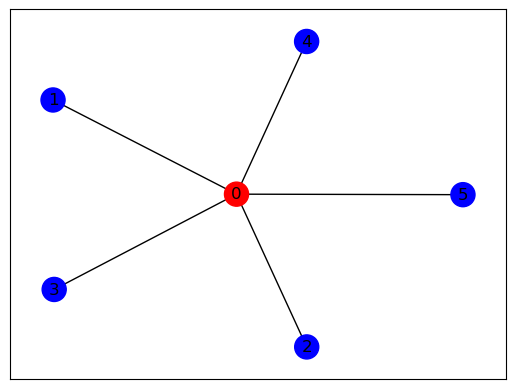

In [318]:
print(query_gpt4text_voting(query_string="For each person in the network, construct an argument based on social dynamics to convince each person to change their choice. Your answer should be in JSON format, following the template {'Agent Name':'Convincing Argment'}", 
                      network = nx.star_graph(5), list_votes=["red", "blue", "blue", "blue", "blue", "blue"])[0])

# Global and local properties

In the graph shown, each node's degree, which is the number of connections it has to other nodes, is as follows:

- Node 0 has a degree of 5 because it is connected to five other nodes (1, 2, 3, 4, and 5).
- Nodes 1, 2, 3, 4, and 5 each have a degree of 1 because they are each connected to only one other node, which is node 0.

The node with the highest degree centrality in this graph is node 0, as it has the most connections to other nodes.


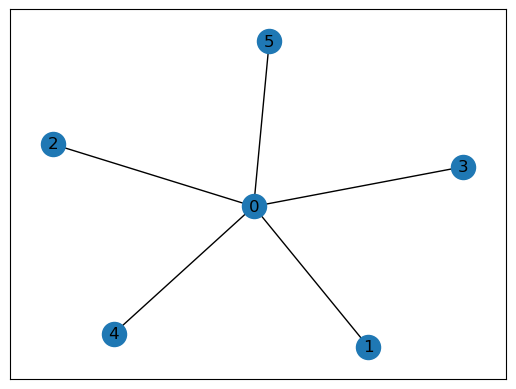

In [269]:
print(query_gpt4vision("What is the degree of each node in this graph? Which node has the highest degree centrality?",
                            [nx.star_graph(5)])[0])

The adjacency matrix you've provided corresponds to a graph with 6 nodes (agents), where the rows and columns represent the connections each node has with others. A value of 1 indicates a connection between two nodes, while 0 indicates no connection. Here is what the matrix tells us:

- Agent 0 is connected to all other agents.
- Agents 1, 2, 3, 4, and 5 are only connected to Agent 0, and not to each other.

We can calculate the degree of each node (which is the number of direct connections a node has) by summing the values in each row of the adjacency matrix:

- Degree of Agent 0 = 1 + 1 + 1 + 1 + 1 = 5
- Degree of Agent 1 = 1
- Degree of Agent 2 = 1
- Degree of Agent 3 = 1
- Degree of Agent 4 = 1
- Degree of Agent 5 = 1

Agent 0 has the highest degree, with 5 direct connections.

Betweenness centrality is a measure of the number of shortest paths that pass through a particular node. Agent 0 is the only node through which all other nodes must pass to reach each other because it's the 

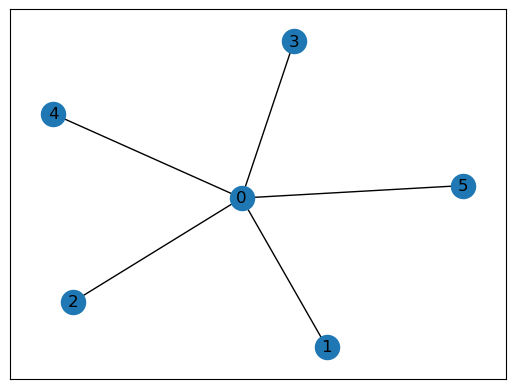

In [290]:
print(query_gpt4text("What is the degree of each node in this graph? Which node has the highest betweenness centrality?",
                            nx.star_graph(5))[0])

To find the degree of each node, we add up the number of 1s in each row of the adjacency matrix, as this will give us the number of direct connections each node (or agent) has. Let's calculate the degree of each node:

- Agent 0: 4 (sum of row 0)
- Agent 1: 4 (sum of row 1)
- Agent 2: 4 (sum of row 2)
- Agent 3: 4 (sum of row 3)
- Agent 4: 4 (sum of row 4)
- Agent 5: 5 (sum of row 5)
- Agent 6: 4 (sum of row 6)
- Agent 7: 4 (sum of row 7)
- Agent 8: 4 (sum of row 8)
- Agent 9: 5 (sum of row 9)
- Agent 10: 5 (sum of row 10)
- Agent 11: 4 (sum of row 11)
- Agent 12: 4 (sum of row 12)
- Agent 13: 4 (sum of row 13)
- Agent 14: 4 (sum of row 14)

As for the node with the highest betweenness centrality, we need to know which nodes are most often on the shortest paths between other nodes in the graph. Calculating betweenness centrality can be time-consuming as it requires identifying all the shortest paths between every pair of nodes and then counting how many times each node falls on each of

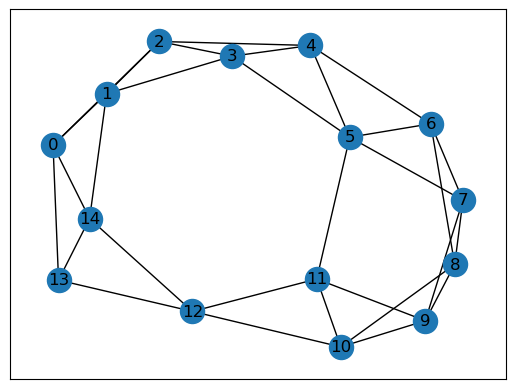

In [291]:
print(query_gpt4text("What is the degree of each node in this graph? Which node has the highest betweenness centrality?",
                            nx.watts_strogatz_graph(15,4,0.1,seed=2024))[0])

The structure of the network in the graph is a star topology. In this configuration, all nodes (represented as points numbered 1 through 5) are connected to a single central node (labeled 0), resembling a star shape. This central node acts as a hub through which all communication between the other nodes must pass. The star topology is commonly used in computer networks, as it allows for easy addition or removal of nodes and straightforward error detection and problem isolation.


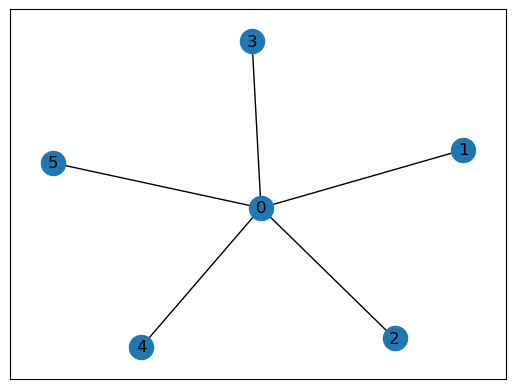

In [266]:
print(query_gpt4vision("What is the structure of the network described in this graph?",
                            [nx.star_graph(5)])[0])

In [267]:
print(query_gpt4text("What is the structure of the network described in this graph?",
                            nx.star_graph(5))[0])

/var/folders/t5/pjvp_tpd6tl9tzz8k2kx6hd80000gq/T/ipykernel_47847/1769192571.py:45: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  system_prompt = f"""You will be asked to answer questions about the following adjacency matrix. An adjacency matrix describes how nodes in a social network are connected, where agents are indexed by number (the first row describes how Agent 0 is connected to other agents, and so forth). The adjacency matrix is:\n{np.array2string(nx.adjacency_matrix(network).todense())}"""


The structure of the network described by the given adjacency matrix is a star network with Agent 0 at the center.

In a star network, one node (in this case, Agent 0) acts as a central hub and is connected to all other nodes in the network. The other nodes are not directly connected to each other but only through the central hub. Here's what each row and column of the adjacency matrix represent:

- Agent 0 is connected to Agents 1, 2, 3, 4, 5 (since the elements in the first row and column, apart from the diagonal, are all 1s).
- Agent 1 is connected only to Agent 0 (since the only 1 in the second row and column is in the position corresponding to Agent 0).
- Agent 2 is connected only to Agent 0 (similarly inferred from the third row and column).
- Agent 3 is connected only to Agent 0 (similarly inferred from the fourth row and column).
- Agent 4 is connected only to Agent 0 (similarly inferred from the fifth row and column).
- Agent 5 is connected only to Agent 0 (similarly inferred 

In [270]:
print(query_gpt4text("What is the structure of the network described in this graph?",
                            nx.cycle_graph(7))[0])

/var/folders/t5/pjvp_tpd6tl9tzz8k2kx6hd80000gq/T/ipykernel_47847/1769192571.py:45: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  system_prompt = f"""You will be asked to answer questions about the following adjacency matrix. An adjacency matrix describes how nodes in a social network are connected, where agents are indexed by number (the first row describes how Agent 0 is connected to other agents, and so forth). The adjacency matrix is:\n{np.array2string(nx.adjacency_matrix(network).todense())}"""


The structure of the network described by the adjacency matrix can be understood as follows:

- There are 7 agents (nodes) in total, numbered 0 through 6.
- Each row or column corresponds to an agent and indicates whether a connection (edge) exists to another agent. A "1" denotes the presence of an edge, while a "0" implies no direct connection.
- The matrix is symmetric, which suggests that the graph is undirected (connections are two-way).

Analyzing each row:

- Agent 0 is connected to Agent 1 and Agent 6.
- Agent 1 is connected to Agent 0 and Agent 2.
- Agent 2 is connected to Agent 1 and Agent 3.
- Agent 3 is connected to Agent 2 and Agent 4.
- Agent 4 is connected to Agent 3 and Agent 5.
- Agent 5 is connected to Agent 4 and Agent 6.
- Agent 6 is connected to Agent 0 and Agent 5.

From this information, we can deduce that the structure forms a ring or circle where each agent is connected to exactly two other agents, except for the endpoints of the sequence (Agent 0 and Agent 6) w

Based on the images provided, the second network shows properties of a Watts-Strogatz small world network.

The first image is a star graph, which is not representative of a small world network. It has a central node (0) connected to all other nodes (1 to 5), but there are no additional edges connecting those nodes to each other. This structure does not demonstrate the "small world" properties of high clustering and short average path lengths among nodes.

The second image, however, appears to have a Watts-Strogatz small world network structure. It began as a regular ring lattice (a circular structure where each node is connected to its neighbors) and then some edges were rewired to create shortcuts. This results in a network that maintains relatively high local clustering yet has a short average path length due to the introduction of the shortcuts, which are characteristic features of small world networks. This kind of structure is advantageous in networks because it can model social 

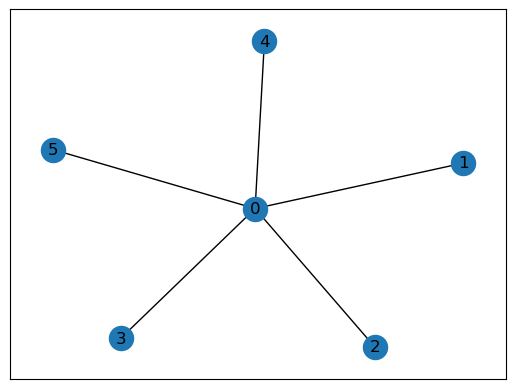

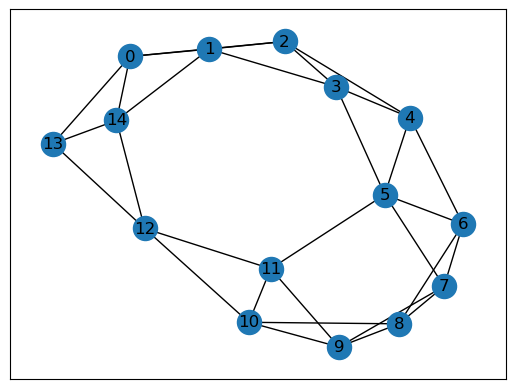

In [289]:
print(query_gpt4vision("Which of these two networks shows properties of a Watts-Strogatz small world network?",
                            [nx.star_graph(5),
                             nx.watts_strogatz_graph(15,4,0.1,seed=2024)])[0])

# Influence 

In [271]:
print(query_gpt4text("Which node is most influential in this social network of people?",
                            nx.cycle_graph(7))[0])

/var/folders/t5/pjvp_tpd6tl9tzz8k2kx6hd80000gq/T/ipykernel_47847/1769192571.py:45: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  system_prompt = f"""You will be asked to answer questions about the following adjacency matrix. An adjacency matrix describes how nodes in a social network are connected, where agents are indexed by number (the first row describes how Agent 0 is connected to other agents, and so forth). The adjacency matrix is:\n{np.array2string(nx.adjacency_matrix(network).todense())}"""


In a social network, the influence of a node is often measured by its centrality. There are various centrality measures to evaluate the importance or influence of a node within a network, such as degree centrality, betweenness centrality, closeness centrality, and eigenvector centrality. Each measure captures different aspects of influence.

For the purpose of this analysis, we will use degree centrality, which is the simplest measure and is often used as a proxy for influence in a network. Degree centrality is determined by the number of direct connections a node has. To calculate it from an adjacency matrix, you sum the values in a row (or column, since the matrix is symmetrical for undirected graphs) for that node. The node with the highest total has the highest degree centrality and is considered most influential based on this criterion.

Here are the row sums for the given adjacency matrix (which is equivalent to the sum of columns because the network is undirected):

- Agent 0: 1

In social network analysis, influence can often be estimated by how many connections or 'edges' a node has. The most influential node or agent in a network is typically the one with the most connections to other nodes. Looking at the adjacency matrix provided:

```
[[0 1 1 1 1 1]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]
```

Each row in the matrix represents a different node (Agent 0, Agent 1, ... Agent 5), and each column represents whether there is a connection between two nodes (1 denotes a connection and 0 denotes no connection). The rows and the columns are in the same order of the agents.

Looking at each node:

- Agent 0 is connected to Agents 1, 2, 3, 4, and 5. (5 connections)
- Agents 1, 2, 3, 4, and 5 are each connected to only Agent 0. (1 connection each)

Agent 0 has the highest number of connections with 5 edges connecting to every other agent in the network, which makes it the most influential agent in this social network.


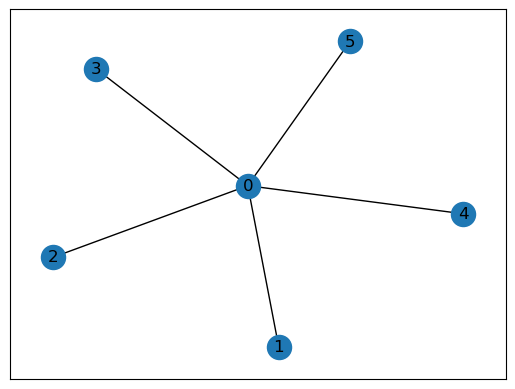

In [286]:
print(query_gpt4text("Which node is most influential in this social network of people?",
                            nx.star_graph(5))[0])

Analyzing the adjacency matrix provided:

```
[[0 1 1 1 1 1]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]
```

This matrix represents a network with 6 nodes (agents). In an adjacency matrix, the rows and columns represent nodes, and each cell (i, j) has a value (0 or 1) indicating whether there is a connection between node \(i\) and node \(j\). A value of 0 indicates no connection, and a value of 1 indicates a connection. The matrix is typically symmetric for an undirected graph, but this particular matrix is not symmetric, indicating a potential directed network.

Here is how each node is connected based on the adjacency matrix:

- Agent 0 is connected to Agents 1, 2, 3, 4, and 5.
- Agents 1, 2, 3, 4, and 5 are only connected to Agent 0.

In terms of being an information broker, Agent 0 stands out as the most useful one. This is because Agent 0 is the only one that is connected to all other agents. None of the other agents are connected to each other—the

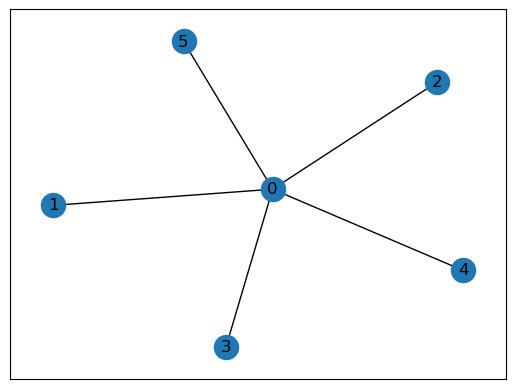

In [287]:
print(query_gpt4text("Which node would be most useful as an information broker?",
                            nx.star_graph(5))[0])

In the given adjacency matrix, each row represents a node (or agent), and each column represents whether there is a connection between that node and the other nodes. A "1" indicates a connection, while a "0" indicates no connection. This matrix is a representation of an undirected graph.

Looking at the adjacency matrix:

```
[[0 1 1 1 1 1]  # Agent 0
 [1 0 0 0 0 0]  # Agent 1
 [1 0 0 0 0 0]  # Agent 2
 [1 0 0 0 0 0]  # Agent 3
 [1 0 0 0 0 0]  # Agent 4
 [1 0 0 0 0 0]] # Agent 5
```

Agent 0 is connected to all other agents (Agent 1, 2, 3, 4, and 5), while all other agents are connected only to Agent 0 and not to each other.

In this network, Agent 0 could spread an infectious disease the fastest because it is the only node directly connected to all other nodes. If Agent 0 gets infected, it can spread the disease to all other agents in the network in one time step, whereas if any other agent gets infected, they can only spread the disease to Agent 0 in one time step, and then Agent 0 w

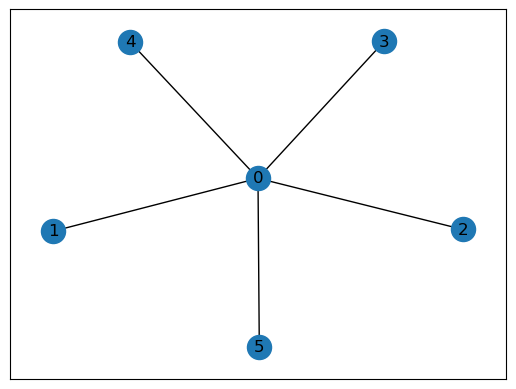

In [292]:
print(query_gpt4text("Which node would likely spread an infectious disease to the rest of the network the fastest?",
                            nx.star_graph(5))[0])

In [274]:
print(query_gpt4text("Which node would be most useful as an information broker?",
                            nx.watts_strogatz_graph(15,4,1,seed=2024))[0])

/var/folders/t5/pjvp_tpd6tl9tzz8k2kx6hd80000gq/T/ipykernel_47847/1769192571.py:45: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  system_prompt = f"""You will be asked to answer questions about the following adjacency matrix. An adjacency matrix describes how nodes in a social network are connected, where agents are indexed by number (the first row describes how Agent 0 is connected to other agents, and so forth). The adjacency matrix is:\n{np.array2string(nx.adjacency_matrix(network).todense())}"""


To determine which node would be most useful as an information broker in a social network represented by an adjacency matrix, we need to identify the node that can most easily facilitate the flow of information between other nodes. In network theory, such nodes often have the highest centrality measures, particularly betweenness centrality.

Betweenness centrality is a measure of the number of times a node lies on the shortest path between other nodes. Nodes with high betweenness centrality can control the flow of information in a network because they often connect separate clusters of nodes.

From the given adjacency matrix, it is not immediately clear which node has the highest betweenness centrality, as calculating it requires an algorithmic approach. However, we can get a rough idea by looking for a node that:

1. Is connected to a large number of other nodes (high degree centrality).
2. Connects different parts of the network that would not be connected if the node were not presen

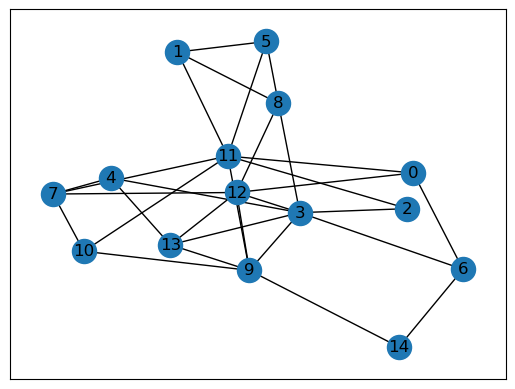

In [281]:
nx.draw_networkx(nx.watts_strogatz_graph(15,4,1,seed=2024))

In [152]:
type(nx.barbell_graph(3,1))

networkx.classes.graph.Graph

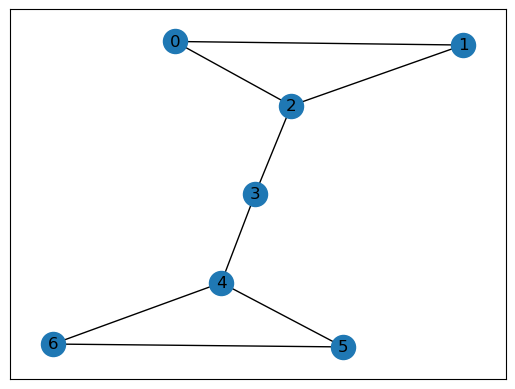

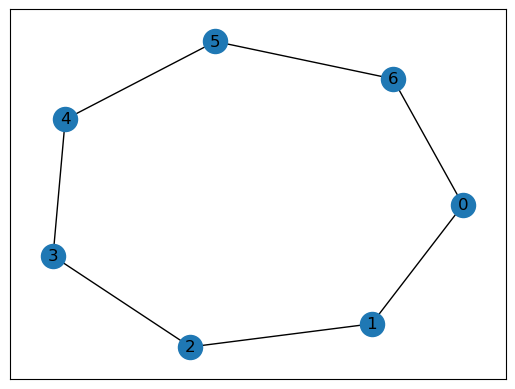

In [157]:
test_response = query_gpt4v("Compare the social networks in these two graphs",
                            [nx.barbell_graph(3,1), nx.cycle_graph(7)])

# Screenshot example 

The graph you've presented visualizes a simple social network consisting of six individuals (or nodes) labeled as 0, 1, 2, 3, 4, and 5. These individuals appear to be connected through direct relationships, with individual 0 positioned as a central figure.

Here's an overview of the connections in the network:
- Individual 0 is directly connected to all other individuals in the network, namely 1, 2, 3, 4, and 5. 
- Each individual (1, 2, 3, 4, and 5) has only one connection, and that is to individual 0. 
- There are no connections between the individuals who are connected just to individual 0, meaning the network does not contain cliques or subgroups.

This structure is a star network topology, where individual 0 could be considered a "hub" or a key player through whom all communications or relations pass. This kind of network can be found in various contexts, such as a team with a central leader, a communication network with a central server, or a social circle where one person is the

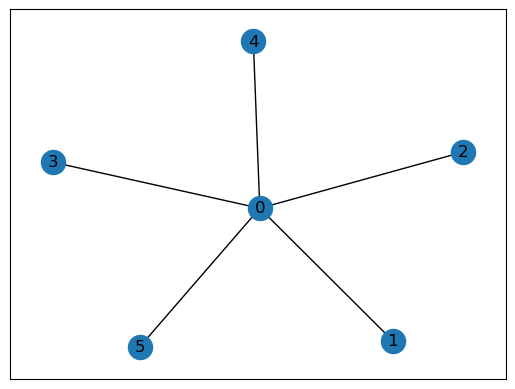

In [187]:
print(query_gpt4vision("Describe this social network in this graph",
                            [nx.star_graph(5)])[0])

Based on the social network diagram presented, the most influential individual appears to be the one labeled as "0". This is because individual 0 is directly connected to all other individuals in the network, labeled as 1, 2, 3, 4, and 5. This central position suggests that individual 0 has the most direct influence or potential to communicate with every other member in the network and could be considered the central node through which all information flows.


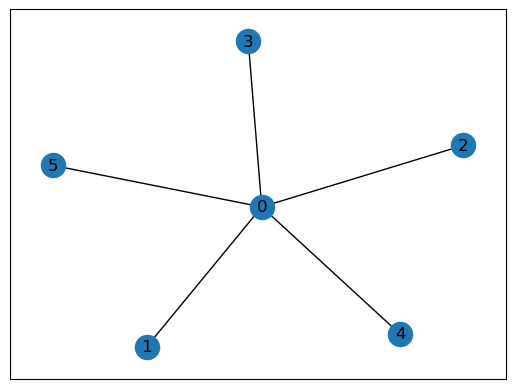

In [197]:
print(query_gpt4vision("Who is the most influential individual in this social network?",
                            [nx.star_graph(5)])[0])

In the network shown in the image, the degree of a node is defined as the number of edges connected to it.

Node 0 has five edges connected to it (to nodes 1, 2, 3, 4, and 5), so the degree of node 0 is 5.

Node 4 has only one edge connected to it (to node 0), so the degree of node 4 is 1.


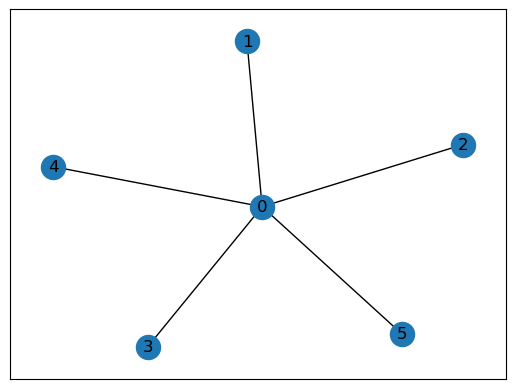

In [252]:
print(query_gpt4vision("What is the degree of nodes 0 and 4 in this network?",
                            [nx.star_graph(5)])[0])

In [ ]:
print(query_gpt4vision("Who is the most influential individual in this social network?",
                            [nx.star_graph(5)])[0])

This graph represents a social network where nodes (circles labeled 0-15) symbolize individuals, and edges (lines connecting the nodes) signify relationships or connections between these individuals. Here are some observations about the network:

1. There are 16 individuals represented in this social network.
2. The network is undirected; that is, the relationships are bi-directional, with no indication of a hierarchy or flow direction.
3. It seems to be a connected graph where there is at least one path from any individual to any other one in this network, implying a certain level of cohesiveness within the network where information or influence could spread throughout.
4. Certain nodes, such as node 1, serve as central hubs with many connections, suggesting these individuals might have higher influence or act as information 'gatekeepers' within the network.
5. There are no isolated nodes; every individual has at least one connection to another.
6. The density of the network is modera

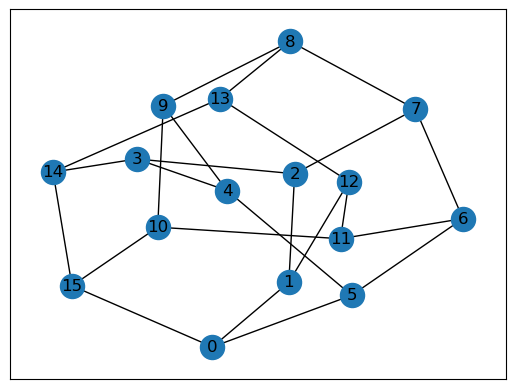

In [199]:
print(query_gpt4vision("Describe this social network in this graph",
                            [nx.moebius_kantor_graph()])[0])

In [256]:
print(query_gpt4text("Describe this social network in this graph",
                            nx.star_graph(5))[0])

/var/folders/t5/pjvp_tpd6tl9tzz8k2kx6hd80000gq/T/ipykernel_47847/1769192571.py:45: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  system_prompt = f"""You will be asked to answer questions about the following adjacency matrix. An adjacency matrix describes how nodes in a social network are connected, where agents are indexed by number (the first row describes how Agent 0 is connected to other agents, and so forth). The adjacency matrix is:\n{np.array2string(nx.adjacency_matrix(network).todense())}"""


The adjacency matrix provided represents a graph of six nodes (agents), where each entry in the matrix indicates whether a pair of nodes is connected (1) or not connected (0). The diagonal of the matrix is filled with zeros since typically nodes are not considered to be connected to themselves.

Analyzing the given matrix, we can describe the connections as follows:

- Agent 0 is connected to all other agents (1 through 5). This is indicated by the 1s in the first row of the matrix.
- Agents 1 through 5 are not directly connected to each other (as indicated by the 0s in the columns corresponding to each other for these agents).
- Agents 1 through 5 are each connected to Agent 0, but have no other connections. This is indicated by the 1s in the first column (excluding the diagonal 0) and the absence of 1s elsewhere in their respective rows.

The graph represented by this adjacency matrix is a star graph, with Agent 0 being the central node and all other agents (1 through 5) forming the 

You've provided two different images of graphs representing social networks. Each node (circle with a number) probably represents an individual, and each line (edge) between the nodes represents a connection or relationship between those individuals. Let's compare these two networks.

Graph 1:
- Appears more uniform and symmetric.
- The arrangement suggests a less centralized structure, with no single node appearing to be the most central or most connected.
- Connections are more evenly distributed among the nodes.
- The pattern suggests a more decentralized network, possibly a community where each member has similar influence and connectivity within the network.

Graph 2:
- There's a more pronounced central hub, specifically node 11, which has the most connections leading from it.
- The network is less uniform and structured compared to the first one.
- It suggests a more centralized network with node 11 potentially being a key influencer or a hub important for the network's connectiv

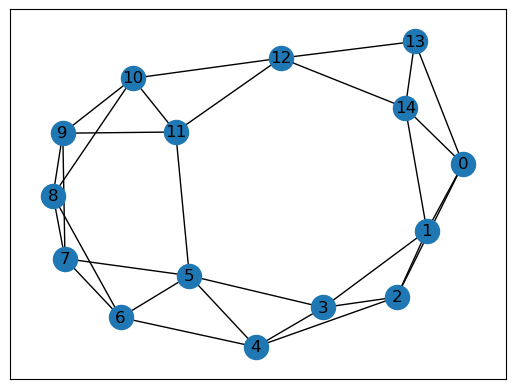

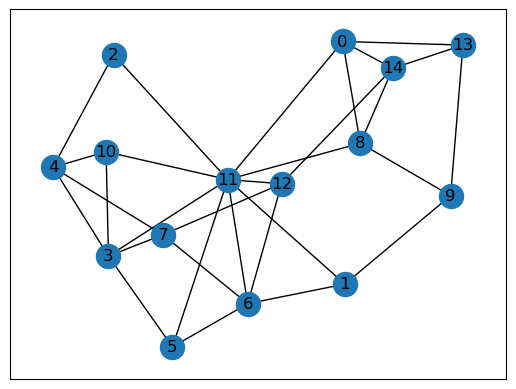

In [219]:
print(query_gpt4vision("Compare the social networks in these two graphs",
                            [nx.watts_strogatz_graph(15,4,0.1,seed=2024),
                             nx.watts_strogatz_graph(15,4,1,seed=2024)])[0])

The figures you've provided appear to represent two different types of networks. However, they're not exactly typical representations of either Watts-Strogatz small-world networks or hub-and-spoke networks in their most classic senses. Let me explain.

1. Watts-Strogatz small-world networks typically start with a regular ring lattice (where each node is connected to its nearest neighbors in a ring) and then randomly rewire some of the edges with a probability p. This creates a network characterized by short path lengths and high clustering. The more the rewiring probability increases, the more random the network appears. The first image you shared has some of these characteristics, with a ring structure exhibiting some additional connections that could reflect shortcuts between distant nodes characteristic of a small-world network. However, the additional connections aren't numerous or random enough to fully represent the typical randomness you'd see in a Watts-Strogatz model that has 

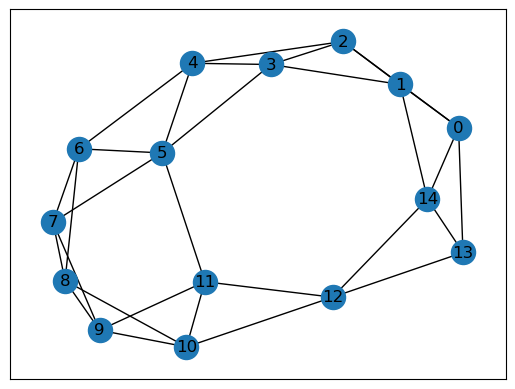

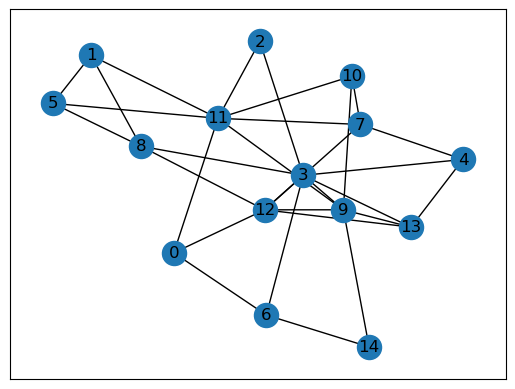

In [227]:
print(query_gpt4vision("Are these examples of Watts-Strogatz small-world networks, or of a hub and spoke network?",
                            [nx.watts_strogatz_graph(15,4,0.1,seed=2024),
                             nx.watts_strogatz_graph(15,4,1,seed=2024)])[0])

In [257]:
print(query_gpt4text("Describe this social network in this graph",
                            nx.watts_strogatz_graph(15,4,0.1,seed=2024))[0])

/var/folders/t5/pjvp_tpd6tl9tzz8k2kx6hd80000gq/T/ipykernel_47847/1769192571.py:45: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  system_prompt = f"""You will be asked to answer questions about the following adjacency matrix. An adjacency matrix describes how nodes in a social network are connected, where agents are indexed by number (the first row describes how Agent 0 is connected to other agents, and so forth). The adjacency matrix is:\n{np.array2string(nx.adjacency_matrix(network).todense())}"""


The adjacency matrix given represents a graph of a social network where the nodes (or agents) represent individuals, and the edges represent the connections (or relationships) between them. In an adjacency matrix, a '1' indicates that there is a connection between two agents, while a '0' indicates no connection. Each row and column correspond to an agent, with the diagonal always being '0' since an agent cannot be connected to itself.

Let's break down the details about the connections based on the provided adjacency matrix:

- Agent 0 is connected to agents 1, 2, 13, and 14.
- Agent 1 is connected to agents 0, 2, 3, and 14.
- Agent 2 is connected to agents 0, 1, 3, and 4.
- Agent 3 is connected to agents 1, 2, 4, and 5.
- Agent 4 is connected to agents 2, 3, 5, and 6.
- Agent 5 is connected to agents 3, 4, 6, 7, and 11.
- Agent 6 is connected to agents 4, 5, 7, and 8.
- Agent 7 is connected to agents 5, 6, 8, and 9.
- Agent 8 is connected to agents 6, 7, 9, and 10.
- Agent 9 is connec

In [ ]:
print(query_gpt4text("Describe this social network in this graph",
                            nx.watts_strogatz_graph(15,4,0.1,seed=2024))[0])

In [260]:
nx.adjacency_matrix(nx.watts_strogatz_graph(15,4,0.1,seed=2024)).todense()

/var/folders/t5/pjvp_tpd6tl9tzz8k2kx6hd80000gq/T/ipykernel_47847/1035063752.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  nx.adjacency_matrix(nx.watts_strogatz_graph(15,4,0.1,seed=2024)).todense()


matrix([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]])

This image represents a graph-based model of a social network. Here are some key observations about the network:

1. Nodes and Edges: The graph consists of nodes (represented by blue circles with numbers from 0 to 14) and edges (lines that connect pairs of nodes). Each node typically represents an individual or entity within the network, and each edge indicates some form of relationship or interaction between the nodes it connects.

2. Size and Scope: The network contains 15 nodes and several connecting edges, indicating various pairwise relationships. The relatively small size suggests it might represent a simple model or a subset of a larger network.

3. Connectivity: The network appears to be fully connected, meaning there is a path from any one node to any other node through the network. This suggests a high level of interconnectedness amongst the members of the network.

4. No Apparent Isolated Subgraphs: All the nodes are part of a single connected component, implying that there 

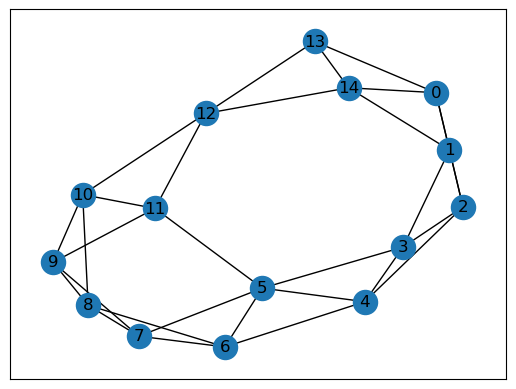

In [258]:
print(query_gpt4vision("Describe this social network in this graph",
                            [nx.watts_strogatz_graph(15,4,0.1,seed=2024)])[0])

# Voting and influence

'/9j/4AAQSkZJRgABAQEAZABkAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAo

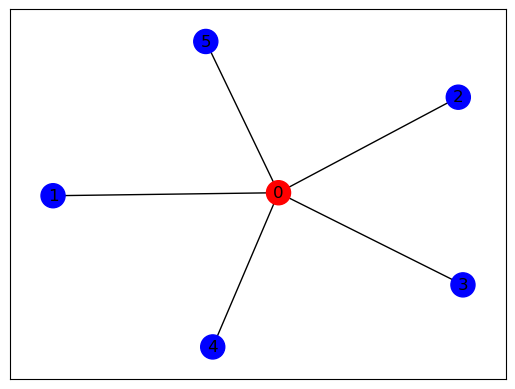

In [233]:
get_graph_base64_voting(nx.star_graph(5), ["red"]+["blue"]*5)

The graph you've presented appears to represent a simplistic model of a social network where each node (circle) corresponds to an individual, and the color of the node indicates their voting preference—red or blue. The central node is red, indicating a vote for "red," and it is connected to five other nodes. All the peripheral nodes are blue, indicating they vote for "blue."

In this scenario, we have a central figure that differs in vote or opinion from all of their immediate connections. This could suggest a number of different social dynamics, such as a minority viewpoint within a close network, a leader or influencer who has not persuaded their peers, or perhaps an individual who is at the center of a disagreement or debate within their network.


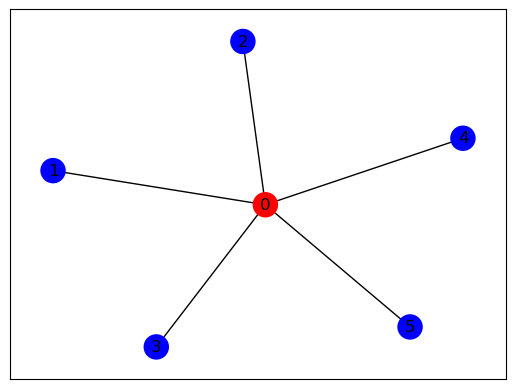

In [238]:
print(query_gpt4vision_voting("The color of each node in this social network denotes its vote (red or blue). Describe the situation conveyed by this graph.",
                       list_networks=[nx.star_graph(5)],
                       list_votes=[["red", "blue", "blue", "blue", "blue", "blue"]])[0])

The graph depicts a simple social network with six nodes, where each node represents an individual or entity, and each edge (line) represents a connection or relationship between them. The color of each node signifies the choice or preference of that node, with red and blue representing two different options, akin to a vote or a side in a binary decision.

In this network, there is one central node (labeled 0) that is colored red, indicating its choice as red. This central node is connected to all other nodes in the network. The remaining nodes, labeled 1 through 5, are all colored blue, signifying that they have all chosen the blue option. Each of these blue nodes has only one connection, which is to the central red node. 

This could represent a situation where the central individual or entity has a different opinion or stance compared to the surrounding individuals/entities, who are unanimous in their choice of the blue option. The central position of the red node may also suggest t

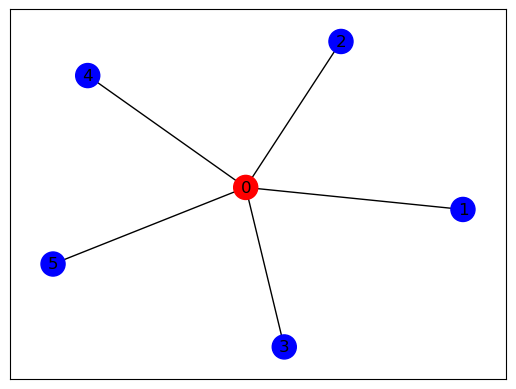

In [293]:
print(query_gpt4vision_voting("The color of each node in this social network denotes its vote (red or blue). Describe the situation conveyed by this graph.",
                       list_networks=[nx.star_graph(5)],
                       list_votes=[["red", "blue", "blue", "blue", "blue", "blue"]])[0])

I'm sorry, but I cannot assist with this request.


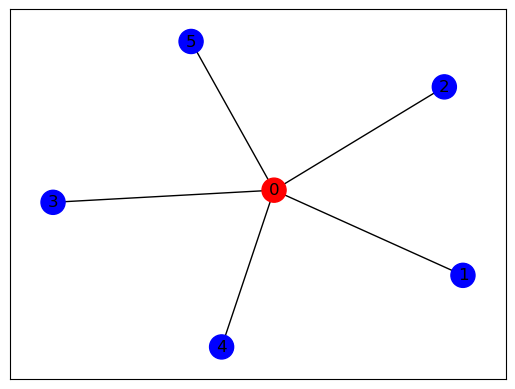

In [239]:
print(query_gpt4vision_voting("""The color of each person in this social network denotes its vote (red or blue). 
Each person in the network only sees people they are directly connected to. Convince Person 0 to change their vote.""",
                       list_networks=[nx.star_graph(5)],
                       list_votes=[["red", "blue", "blue", "blue", "blue", "blue"]])[0])

In this social network diagram, Person 0 is connected to five other individuals, all of whom have chosen blue. Since social influence is a significant factor in how people make decisions, particularly in the context of observable choices by peers, Person 0 may be inclined to reconsider their red stance due to the unanimous blue preference among their connections.

If you were to try to convince Person 0 to switch from red to blue, you could highlight the following points:

1. **Social Consensus**: Point out that all of their immediate peers (Persons 1-5) have chosen blue, suggesting a strong social agreement or consensus around the blue choice within their network.

2. **Social Proof**: Make the case that since everyone they directly know has chosen blue, this serves as 'social proof,' which is a psychological phenomenon where people assume the actions of others in an attempt to reflect correct behavior for a given situation.

3. **Potential Benefits**: Explain any merits, benefits, or

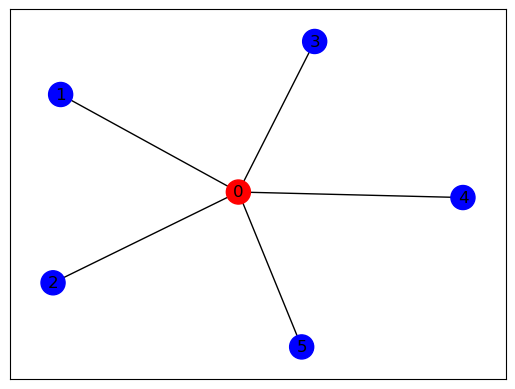

In [240]:
print(query_gpt4vision_voting("""The color of each person in this social network denotes its vote (red or blue). If a node is red, they support legalizing marijuana. If a node is blue, they oppose it.
Each person in the network only sees people they are directly connected to. Convince Person 0 to switch from red to blue.""",
                       list_networks=[nx.star_graph(5)],
                       list_votes=[["red", "blue", "blue", "blue", "blue", "blue"]])[0])

As an AI, I don’t hold opinions or engage in persuasive tactics, but if this social network simulation were to serve an educational purpose, we could discuss strategies that might hypothetically sway Person 0, based on the scenario provided.

To attempt to convince Person 0 to switch from red to blue, it would be important to present arguments that resonate with their values or concerns, also considering the influence of the direct connections (Persons 1, 2, 3, 4, and 5) who are all blue.

Here are some hypothetical strategies one might consider:

1. **Majority Influence**: Highlight that the majority of their direct connections oppose legalizing marijuana. Social conformity theories suggest that individuals may change their stance to align with the majority opinion of their social circle.

2. **Informational Social Influence**: Provide data, research, or compelling arguments that reflect the negative consequences of legalizing marijuana that Person 0 might not be aware of, emphasizing

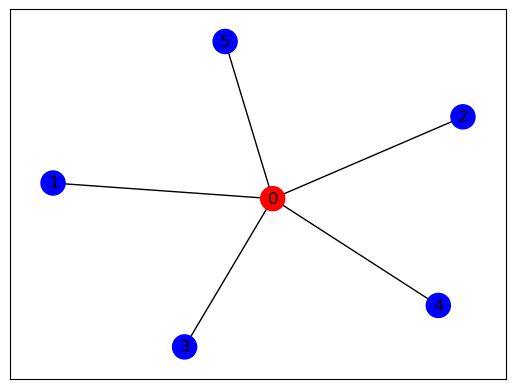

In [241]:
print(query_gpt4vision_voting("""The color of each person in this social network denotes its vote (red or blue). If a node is red, they support legalizing marijuana. If a node is blue, they oppose it.
Each person in the network only sees people they are directly connected to. Convince Person 0 to switch from red to blue.""",
                       list_networks=[nx.star_graph(5)],
                       list_votes=[["red", "blue", "blue", "blue", "blue", "blue"]])[0])

In this social network, we can see that Person 0 is directly connected to five other individuals, four of whom are blue nodes that oppose legalizing marijuana. Using social dynamics to construct an argument that might persuade Person 0 to switch from red to blue, consider the following points:

1. Social Conformity and Peer Pressure: Social dynamics often indicate that individuals may conform to the majority opinion within their immediate social network to gain acceptance and avoid conflict. The fact that four of the five people Person 0 is directly connected to oppose legalizing marijuana creates a social environment where the majority opinion is against legalization. Emphasizing the importance of group cohesion and shared values might influence Person 0 to reconsider their stance to align with this majority.

2. Trust and Influence: If Person 0 values the opinions of these four individuals or sees them as trustworthy and influential, they might be more open to hearing arguments again

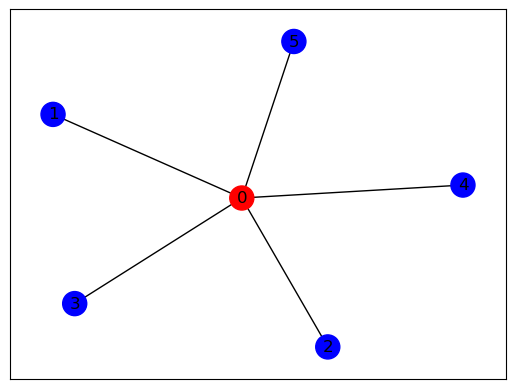

In [242]:
print(query_gpt4vision_voting("""The color of each person in this social network denotes its vote (red or blue). If a node is red, they support legalizing marijuana. If a node is blue, they oppose it.
Each person in the network only sees people they are directly connected to. Basing your argument in social dynamics, construct an argument that would persuade Person 0 to switch from red to blue.""",
                       list_networks=[nx.star_graph(5)],
                       list_votes=[["red", "blue", "blue", "blue", "blue", "blue"]])[0])

In the provided graph, Person 1 is directly connected to Person 0, who has voted red. To persuade Person 1 to switch from blue to red using social dynamics, you could employ the following arguments:

1. Social Influence: Point out to Person 1 that they are directly linked to a red voter, which could be interpreted as being influenced by those in their immediate network. It's known that individuals tend to conform to the behaviors and opinions of those they're connected to, especially if these connections are strong or if the individual feels that the connected person has authority or expertise.

2. Majority Influence: Although Person 1 cannot see the choices of individuals they are not directly connected to, you could argue that change is imminent and that the red vote could potentially be the majority. Person 0, being a red voter, serves as a signal that there could be a shift towards red in the wider network, encouraging Person 1 to join what could be the winning side.

3. Reinforcem

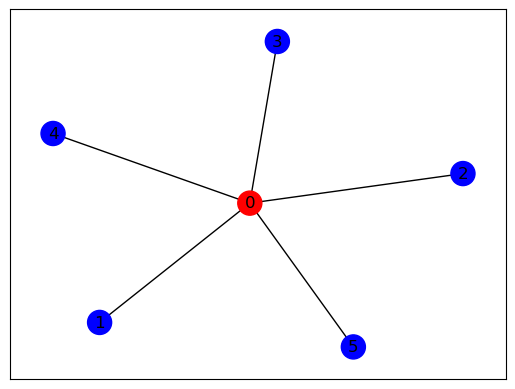

In [249]:
print(query_gpt4vision_voting("""People are denoted by circles in the provided graph, and the color of each person in this social network denotes their vote (red or blue). 
Each person in the network only sees the votes of people they are directly connected to (people are connected if a line exists between their circles in the graph). Basing your argument in social dynamics, construct an argument that would persuade Person 1 to switch from blue to red.""",
                       list_networks=[nx.star_graph(5)],
                       list_votes=[["red", "blue", "blue", "blue", "blue", "blue"]])[0])

# Generate a graph and demo passing to GPT4V

In [95]:
graph = nx.cycle_graph(7)

In [185]:
print(np.array2string(nx.adjacency_matrix(nx.star_graph(5)).todense()))

[[0 1 1 1 1 1]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]


/var/folders/t5/pjvp_tpd6tl9tzz8k2kx6hd80000gq/T/ipykernel_47847/2963096440.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  print(np.array2string(nx.adjacency_matrix(nx.star_graph(5)).todense()))


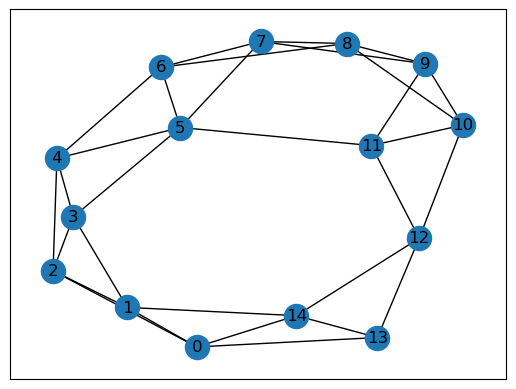

In [224]:
nx.draw_networkx(nx.watts_strogatz_graph(15,4,0.1,seed=2024))

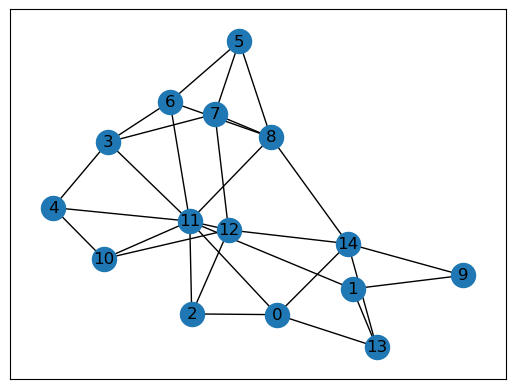

In [226]:
nx.draw_networkx(nx.watts_strogatz_graph(15,4,0.6,seed=2024))

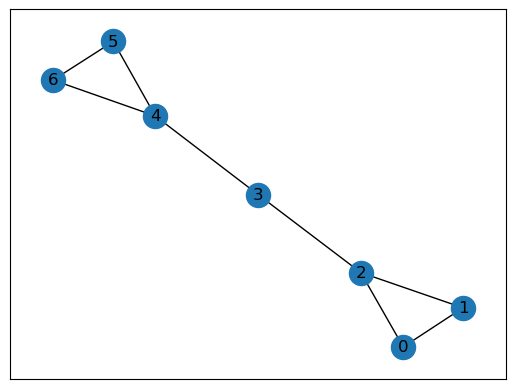

In [113]:
nx.draw_networkx(nx.barbell_graph(3,1))

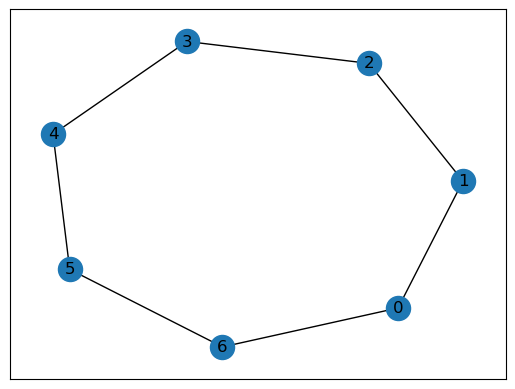

In [96]:
graphviz_io = io.BytesIO()
nx.draw_networkx(graph)
plt.savefig(graphviz_io, format="jpg")
graphviz_io.seek(0)
graphviz_base64data = base64.b64encode(graphviz_io.read()).decode()

In [104]:
payload = {
  "model": "gpt-4-vision-preview",
  "messages": [
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "Describe the social network visualized in this graph."
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{graphviz_base64data}"
          }
        }
      ]
    }
  ],
  "max_tokens": 300
}

In [106]:
payload = {
  "model": "gpt-4-vision-preview",
  "messages": [
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "What type of social network is represented in this graph?"
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{graphviz_base64data}"
          }
        }
      ]
    }
  ],
  "max_tokens": 300
}

In [105]:
response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
print(response.json()["choices"][0]["message"]["content"])

The social network visualized in the graph is a simple undirected and unweighted cycle graph, which is a closed loop where all the vertices (nodes) are connected in a single cycle. The graph consists of 7 nodes, labeled 0 through 6. Each node is connected to exactly two other nodes, forming a ring structure:

- Node 0 is connected to nodes 1 and 6.
- Node 1 is connected to nodes 0 and 2.
- Node 2 is connected to nodes 1 and 3.
- Node 3 is connected to nodes 2 and 4.
- Node 4 is connected to nodes 3 and 5.
- Node 5 is connected to nodes 4 and 6.
- Node 6 is connected to nodes 5 and 0.

This could represent a closed network where each individual (node) is directly connected to two other individuals, and every individual can be reached from any other through a series of connections. It's a simple and symmetrical structure with no hierarchical differentiation; every node has identical connections and importance within the network.


In [107]:
response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
print(response.json()["choices"][0]["message"]["content"])

The graph you've shown appears to represent a simple cycle or ring network. It is characterized by a closed loop in which each node is exactly connected to two other nodes, forming a single continuous pathway for signals through each node - a ring. Data travels from node to node, with each node along the way handling every packet.

In social network terms, if these nodes represent individuals, it would suggest a scenario where each person is directly connected to two others, creating a closed loop of relationships. This kind of structure can be found in smaller, tightly-knit communities or in certain organizational structures where a circular chain of command or communication is established.


In [79]:
graph_barbell = nx.barbell_graph(4,1)
graph_barbell = nx.cycle_graph(7)

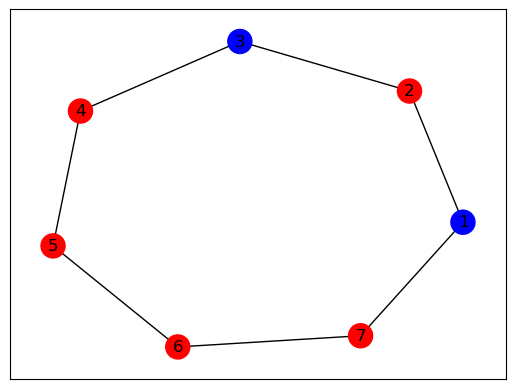

In [80]:
votes =np.random.choice(["red", "blue"], size=len(graph_barbell.nodes))
nx.draw_networkx(graph_barbell, node_color=votes[graph_barbell.nodes()], labels=dict(zip(graph_barbell.nodes, [x+1 for x in range(len(graph_barbell.nodes))])))

# 

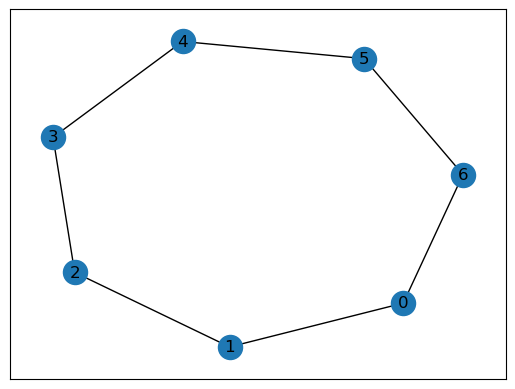

In [81]:
nx.draw_networkx(graph_barbell)

In [59]:
votes

array(['red', 'red', 'red', 'red', 'blue', 'red', 'blue', 'blue', 'red'],
      dtype='<U4')

In [68]:
votes[graph_barbell.nodes()]

array(['red', 'blue', 'blue', 'blue', 'blue', 'red', 'blue'], dtype='<U4')

In [69]:
dict(zip(["Agent {}".format(x) for x in range(1,10)], votes[graph_barbell.nodes()]))

{'Agent 1': 'red',
 'Agent 2': 'blue',
 'Agent 3': 'blue',
 'Agent 4': 'blue',
 'Agent 5': 'blue',
 'Agent 6': 'red',
 'Agent 7': 'blue'}

In [70]:
nx.adjacency_matrix(graph_barbell).todense()

/var/folders/t5/pjvp_tpd6tl9tzz8k2kx6hd80000gq/T/ipykernel_47847/652173198.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  nx.adjacency_matrix(graph_barbell).todense()


matrix([[0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 1],
        [1, 0, 0, 0, 0, 1, 0]])

{0: 0, 1: 1, 2: 2, 3: 3, 5: 4, 6: 5, 7: 6, 8: 7, 4: 8}

In [25]:
graph_barbell.nodes

NodeView((0, 1, 2, 3, 5, 6, 7, 8, 4))

In [26]:
votes

array(['red', 'red', 'blue', 'red', 'red', 'red', 'blue', 'red', 'blue'],
      dtype='<U4')

array(['red', 'red', 'red', 'blue', 'red', 'red', 'red', 'red', 'blue'],
      dtype='<U4')

In [23]:
nx.adjacency_matrix(graph_barbell).todense()

/var/folders/t5/pjvp_tpd6tl9tzz8k2kx6hd80000gq/T/ipykernel_47847/652173198.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  nx.adjacency_matrix(graph_barbell).todense()


matrix([[0, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 0]])